# Emotion Recognition Modeling Pipeline
**Contributor:** Pratheek Sankeshi (psankesh9@berkeley.edu)

**Project:** Emotional Vocalization Classification

This notebook implements:
1. **Feature Engineering** - Normalization, PCA, feature selection
2. **Baseline Models** - SVM, Random Forest, XGBoost
3. **Data Augmentation** - Pitch shifting, time stretching, noise addition
4. **Deep Learning** - CNN and LSTM architectures
5. **Cross-Validation** - Stratified K-fold and speaker-independent validation

## 1. Setup and Imports

In [4]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# Sklearn preprocessing and feature selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Classical ML models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.15.0
GPU available: []


In [3]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 6.7 MB/s eta 0:00:11
   - -------------------------------------- 1.8/72.0 MB 5.9 MB/s eta 0:00:12
   - -------------------------------------- 3.1/72.0 MB 5.4 MB/s eta 0:00:13
   -- ------------------------------------- 4.7/72.0 MB 6.1 MB/s eta 0:00:12
   ----- ---------------------------------- 9.7/72.0 MB 9.9 MB/s eta 0:00:07
   ------- -------------------------------- 13.4/72.0 MB 11.3 MB/s eta 0:00:06
   ----------- ---------------------------- 19.9/72.0 MB 14.3 MB/s eta 0:00:04
   -------------- ------------------------- 26.0/72.0 MB 16.4 MB/s eta 0:00:03
   ------------------ --------------------- 33.0/72.0 MB 18.1 MB/s eta 0:00:03
   ---------------------- ----------------- 39.8/72.0 MB 19.6 MB/s eta 0:00:02
   ------------------------- -------------- 46.4/72.0 MB 20.8 MB/s eta 0


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Load Processed Features

In [5]:
# Load the features from EDA notebook
FEATURES_PATH = 'D:/EDFS_Data/processed/processed_features.csv'
DATASET_PATH = Path('D:/EDFS_Data/RAVDESS/raw')

df = pd.read_csv(FEATURES_PATH)
print(f"Loaded {len(df)} samples with {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nEmotion distribution:\n{df['emotion'].value_counts().sort_index()}")
df.head()

Loaded 1440 samples with 36 columns

Columns: ['duration', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms_energy', 'pitch_mean', 'mfcc1_mean', 'mfcc1_std', 'mfcc2_mean', 'mfcc2_std', 'mfcc3_mean', 'mfcc3_std', 'mfcc4_mean', 'mfcc4_std', 'mfcc5_mean', 'mfcc5_std', 'mfcc6_mean', 'mfcc6_std', 'mfcc7_mean', 'mfcc7_std', 'mfcc8_mean', 'mfcc8_std', 'mfcc9_mean', 'mfcc9_std', 'mfcc10_mean', 'mfcc10_std', 'mfcc11_mean', 'mfcc11_std', 'mfcc12_mean', 'mfcc12_std', 'mfcc13_mean', 'mfcc13_std', 'emotion', 'gender', 'actor']

Emotion distribution:
emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: count, dtype: int64


,duration,spectral_centroid,spectral_bandwidth,spectral_rolloff,zcr,rms_energy,pitch_mean,mfcc1_mean,mfcc1_std,mfcc2_mean,...,mfcc10_std,mfcc11_mean,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std,emotion,gender,actor
0,3.303311,3470.937689,2628.243580,6330.385264,0.372712,0.002256,1772.7737,-697.79260,183.03044,54.890040,...,8.865101,0.815298,8.669750,-3.037067,9.678136,1.955447,9.780214,neutral,male,1
1,3.336689,3264.835349,2675.836121,6237.152100,0.380551,0.002419,1778.1255,-692.85580,185.05030,55.363895,...,8.362707,0.843715,9.127845,-2.641278,9.430248,1.017250,9.277677,neutral,male,1
2,3.269932,3233.896121,2633.346044,6180.487450,0.399123,0.002809,1789.1708,-691.58790,190.33614,58.024662,...,9.160270,0.560600,9.703084,-2.838225,8.179122,1.834785,9.952105,neutral,male,1
3,3.169841,3114.655307,2675.402307,6165.490455,0.396930,0.002617,1712.2599,-685.10547,184.56506,55.879420,...,8.596281,1.176165,8.642621,-1.498656,8.127197,0.551550,7.379322,neutral,male,1
4,3.536871,3226.498012,2629.698536,6070.041073,0.356985,0.001653,1811.1483,-727.10440,182.82188,62.355034,...,9.228117,0.996316,11.612597,-3.116070,8.898349,0.546321,7.958459,calm,male,1


## 3. Feature Engineering

### 3.1 Prepare Features and Labels

In [6]:
# Separate features and labels
feature_cols = [col for col in df.columns if col not in ['emotion', 'gender', 'actor']]
X = df[feature_cols].values
y = df['emotion'].values
actor_ids = df['actor'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y_encoded.shape}")
print(f"\nEmotion encoding:")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"  {emotion}: {i}")

Feature matrix shape: (1440, 33)
Labels shape: (1440,)

Emotion encoding:
  angry: 0
  calm: 1
  disgust: 2
  fearful: 3
  happy: 4
  neutral: 5
  sad: 6
  surprised: 7


### 3.2 Feature Normalization

In [7]:
# Standardize features (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling complete.")
print(f"Original mean: {X.mean(axis=0)[:5]}")
print(f"Scaled mean: {X_scaled.mean(axis=0)[:5]}")
print(f"Scaled std: {X_scaled.std(axis=0)[:5]}")

Feature scaling complete.
Original mean: [3.70068783e+00 2.91825069e+03 2.52004568e+03 5.62968946e+03
 2.52522904e-01]
Scaled mean: [-3.55271368e-16  1.07568275e-15  2.36847579e-16 -9.86864911e-18
 -3.94745964e-16]
Scaled std: [1. 1. 1. 1. 1.]


### 3.3 Principal Component Analysis (PCA)

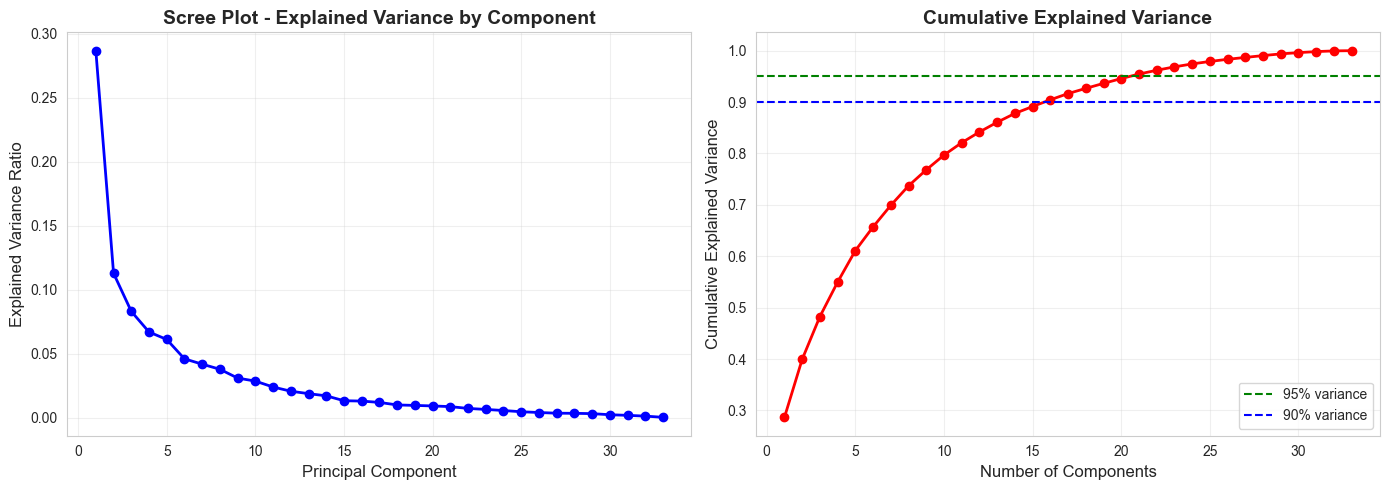


Components needed for 90% variance: 16
Components needed for 95% variance: 21
Total components: 33

Reduced feature shape: (1440, 21)


In [8]:
# Apply PCA to understand variance distribution
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_, 'bo-', linewidth=2)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Scree Plot - Explained Variance by Component', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'ro-', linewidth=2)
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='b', linestyle='--', label='90% variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal number of components
n_components_90 = np.argmax(cumsum >= 0.90) + 1
n_components_95 = np.argmax(cumsum >= 0.95) + 1

print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")
print(f"Total components: {X_scaled.shape[1]}")

# Create PCA-reduced features (95% variance)
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)
print(f"\nReduced feature shape: {X_pca.shape}")

### 3.4 Feature Selection (Mutual Information)

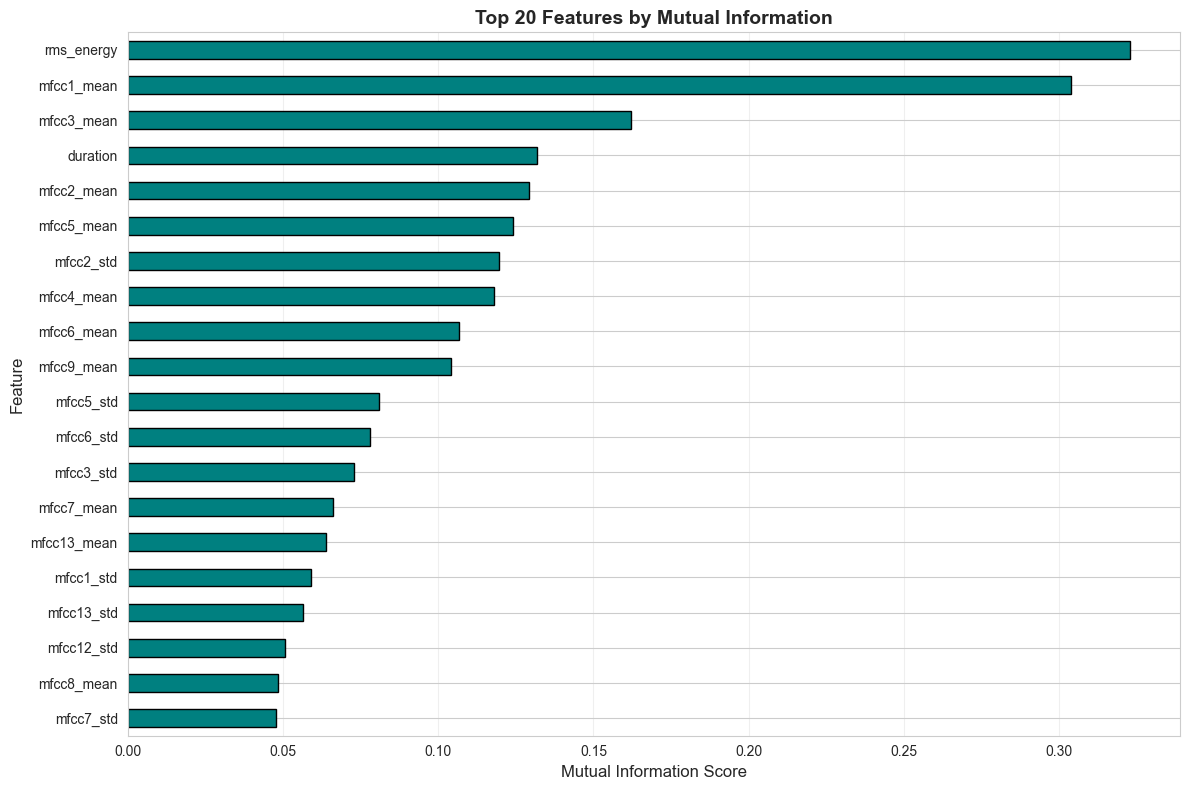


Selected 20 best features:
['duration' 'rms_energy' 'mfcc1_mean' 'mfcc1_std' 'mfcc2_mean' 'mfcc2_std'
 'mfcc3_mean' 'mfcc3_std' 'mfcc4_mean' 'mfcc5_mean' 'mfcc5_std'
 'mfcc6_mean' 'mfcc6_std' 'mfcc7_mean' 'mfcc7_std' 'mfcc8_mean'
 'mfcc9_mean' 'mfcc12_std' 'mfcc13_mean' 'mfcc13_std']

Selected features shape: (1440, 20)


In [9]:
# Use mutual information to select top features
mi_scores = mutual_info_classif(X_scaled, y_encoded, random_state=42)
mi_scores = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
mi_scores[:20].plot(kind='barh', color='teal', edgecolor='black')
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by Mutual Information', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Select top k features
k_best = 20
selector = SelectKBest(mutual_info_classif, k=k_best)
X_selected = selector.fit_transform(X_scaled, y_encoded)
selected_features = np.array(feature_cols)[selector.get_support()]

print(f"\nSelected {k_best} best features:")
print(selected_features)
print(f"\nSelected features shape: {X_selected.shape}")

## 4. Cross-Validation Strategy

We'll use two validation strategies:
1. **Stratified K-Fold** - Standard approach maintaining class balance
2. **Leave-One-Speaker-Out (LOSO)** - More realistic for speaker-independent evaluation

In [10]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Also create train/test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Same split for PCA features
X_train_pca, X_test_pca, _, _ = train_test_split(
    X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Same split for selected features
X_train_sel, X_test_sel, _, _ = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Training set size: (1152, 33)
Test set size: (288, 33)

Training class distribution: [154 154 154 153 153  77 154 153]
Test class distribution: [38 38 38 39 39 19 38 39]


## 5. Baseline Models Training

### 5.1 Support Vector Machine (SVM)

In [11]:
print("Training SVM with different feature sets...\n")

# SVM with full features
svm_full = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
cv_scores_svm_full = cross_val_score(svm_full, X_scaled, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
svm_full.fit(X_train, y_train)
y_pred_svm_full = svm_full.predict(X_test)
acc_svm_full = accuracy_score(y_test, y_pred_svm_full)

print(f"SVM (Full Features):")
print(f"  CV Accuracy: {cv_scores_svm_full.mean():.4f} (+/- {cv_scores_svm_full.std():.4f})")
print(f"  Test Accuracy: {acc_svm_full:.4f}\n")

# SVM with PCA features
svm_pca = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
cv_scores_svm_pca = cross_val_score(svm_pca, X_pca, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
svm_pca.fit(X_train_pca, y_train)
y_pred_svm_pca = svm_pca.predict(X_test_pca)
acc_svm_pca = accuracy_score(y_test, y_pred_svm_pca)

print(f"SVM (PCA Features):")
print(f"  CV Accuracy: {cv_scores_svm_pca.mean():.4f} (+/- {cv_scores_svm_pca.std():.4f})")
print(f"  Test Accuracy: {acc_svm_pca:.4f}\n")

# SVM with selected features
svm_sel = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
cv_scores_svm_sel = cross_val_score(svm_sel, X_selected, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
svm_sel.fit(X_train_sel, y_train)
y_pred_svm_sel = svm_sel.predict(X_test_sel)
acc_svm_sel = accuracy_score(y_test, y_pred_svm_sel)

print(f"SVM (Selected Features):")
print(f"  CV Accuracy: {cv_scores_svm_sel.mean():.4f} (+/- {cv_scores_svm_sel.std():.4f})")
print(f"  Test Accuracy: {acc_svm_sel:.4f}")

Training SVM with different feature sets...

SVM (Full Features):
  CV Accuracy: 0.7340 (+/- 0.0238)
  Test Accuracy: 0.7500

SVM (PCA Features):
  CV Accuracy: 0.7236 (+/- 0.0271)
  Test Accuracy: 0.7361

SVM (Selected Features):
  CV Accuracy: 0.7063 (+/- 0.0251)
  Test Accuracy: 0.6806


### 5.2 Random Forest

Training Random Forest with different feature sets...

Random Forest (Full Features):
  CV Accuracy: 0.6583 (+/- 0.0187)
  Test Accuracy: 0.6424

Random Forest (PCA Features):
  CV Accuracy: 0.6000 (+/- 0.0156)
  Test Accuracy: 0.5938

Random Forest (Selected Features):
  CV Accuracy: 0.6424 (+/- 0.0193)
  Test Accuracy: 0.6250


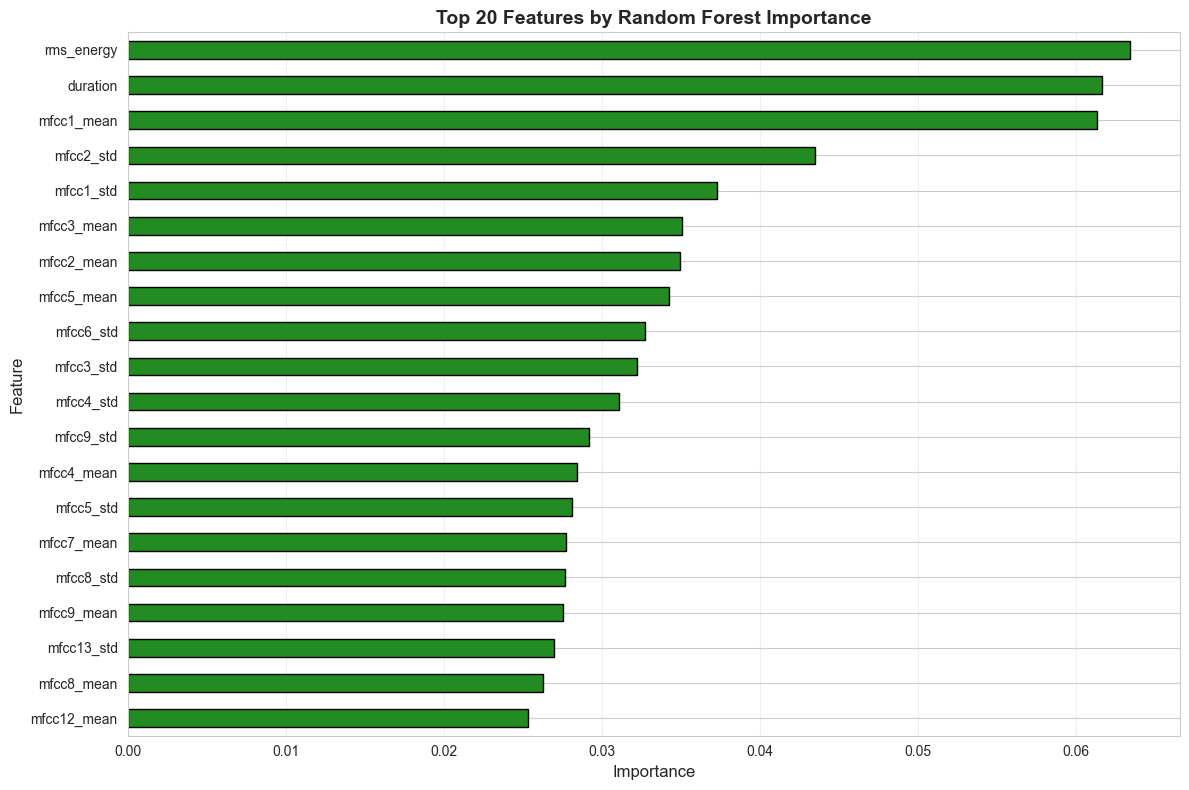

In [12]:
print("Training Random Forest with different feature sets...\n")

# Random Forest with full features
rf_full = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)
cv_scores_rf_full = cross_val_score(rf_full, X_scaled, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
rf_full.fit(X_train, y_train)
y_pred_rf_full = rf_full.predict(X_test)
acc_rf_full = accuracy_score(y_test, y_pred_rf_full)

print(f"Random Forest (Full Features):")
print(f"  CV Accuracy: {cv_scores_rf_full.mean():.4f} (+/- {cv_scores_rf_full.std():.4f})")
print(f"  Test Accuracy: {acc_rf_full:.4f}\n")

# Random Forest with PCA features
rf_pca = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)
cv_scores_rf_pca = cross_val_score(rf_pca, X_pca, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_pca.predict(X_test_pca)
acc_rf_pca = accuracy_score(y_test, y_pred_rf_pca)

print(f"Random Forest (PCA Features):")
print(f"  CV Accuracy: {cv_scores_rf_pca.mean():.4f} (+/- {cv_scores_rf_pca.std():.4f})")
print(f"  Test Accuracy: {acc_rf_pca:.4f}\n")

# Random Forest with selected features
rf_sel = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)
cv_scores_rf_sel = cross_val_score(rf_sel, X_selected, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
rf_sel.fit(X_train_sel, y_train)
y_pred_rf_sel = rf_sel.predict(X_test_sel)
acc_rf_sel = accuracy_score(y_test, y_pred_rf_sel)

print(f"Random Forest (Selected Features):")
print(f"  CV Accuracy: {cv_scores_rf_sel.mean():.4f} (+/- {cv_scores_rf_sel.std():.4f})")
print(f"  Test Accuracy: {acc_rf_sel:.4f}")

# Feature importance from best RF model
feature_importance = pd.Series(rf_full.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
feature_importance[:20].plot(kind='barh', color='forestgreen', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3 XGBoost

In [13]:
print("Training XGBoost with different feature sets...\n")

# XGBoost with full features
xgb_full = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss')
cv_scores_xgb_full = cross_val_score(xgb_full, X_scaled, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_full.fit(X_train, y_train)
y_pred_xgb_full = xgb_full.predict(X_test)
acc_xgb_full = accuracy_score(y_test, y_pred_xgb_full)

print(f"XGBoost (Full Features):")
print(f"  CV Accuracy: {cv_scores_xgb_full.mean():.4f} (+/- {cv_scores_xgb_full.std():.4f})")
print(f"  Test Accuracy: {acc_xgb_full:.4f}\n")

# XGBoost with PCA features
xgb_pca = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss')
cv_scores_xgb_pca = cross_val_score(xgb_pca, X_pca, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_pca.fit(X_train_pca, y_train)
y_pred_xgb_pca = xgb_pca.predict(X_test_pca)
acc_xgb_pca = accuracy_score(y_test, y_pred_xgb_pca)

print(f"XGBoost (PCA Features):")
print(f"  CV Accuracy: {cv_scores_xgb_pca.mean():.4f} (+/- {cv_scores_xgb_pca.std():.4f})")
print(f"  Test Accuracy: {acc_xgb_pca:.4f}\n")

# XGBoost with selected features
xgb_sel = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss')
cv_scores_xgb_sel = cross_val_score(xgb_sel, X_selected, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_sel.fit(X_train_sel, y_train)
y_pred_xgb_sel = xgb_sel.predict(X_test_sel)
acc_xgb_sel = accuracy_score(y_test, y_pred_xgb_sel)

print(f"XGBoost (Selected Features):")
print(f"  CV Accuracy: {cv_scores_xgb_sel.mean():.4f} (+/- {cv_scores_xgb_sel.std():.4f})")
print(f"  Test Accuracy: {acc_xgb_sel:.4f}")

Training XGBoost with different feature sets...

XGBoost (Full Features):
  CV Accuracy: 0.6361 (+/- 0.0218)
  Test Accuracy: 0.6042

XGBoost (PCA Features):
  CV Accuracy: 0.5743 (+/- 0.0125)
  Test Accuracy: 0.5660

XGBoost (Selected Features):
  CV Accuracy: 0.6181 (+/- 0.0275)
  Test Accuracy: 0.6146


### 5.4 Baseline Models Comparison


=== BASELINE MODELS PERFORMANCE ===

Model Features  CV Accuracy   CV Std  Test Accuracy
  SVM     Full     0.734028 0.023814       0.750000
  SVM      PCA     0.723611 0.027128       0.736111
  SVM Selected     0.706250 0.025096       0.680556
   RF     Full     0.658333 0.018711       0.642361
   RF      PCA     0.600000 0.015590       0.593750
   RF Selected     0.642361 0.019270       0.625000
  XGB     Full     0.636111 0.021784       0.604167
  XGB      PCA     0.574306 0.012539       0.565972
  XGB Selected     0.618056 0.027516       0.614583


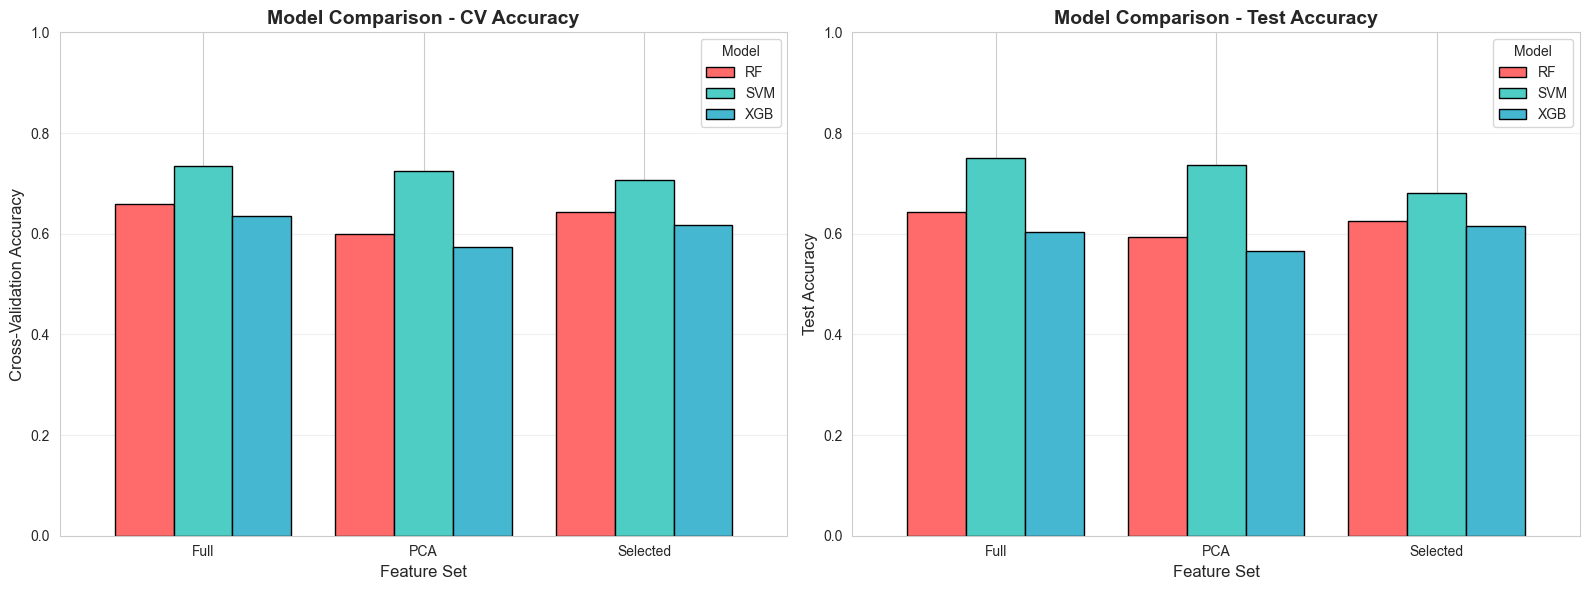


Best baseline model: SVM with Full features
Test Accuracy: 0.7500


In [14]:
# Compile results
baseline_results = pd.DataFrame({
    'Model': ['SVM', 'SVM', 'SVM', 'RF', 'RF', 'RF', 'XGB', 'XGB', 'XGB'],
    'Features': ['Full', 'PCA', 'Selected'] * 3,
    'CV Accuracy': [
        cv_scores_svm_full.mean(), cv_scores_svm_pca.mean(), cv_scores_svm_sel.mean(),
        cv_scores_rf_full.mean(), cv_scores_rf_pca.mean(), cv_scores_rf_sel.mean(),
        cv_scores_xgb_full.mean(), cv_scores_xgb_pca.mean(), cv_scores_xgb_sel.mean()
    ],
    'CV Std': [
        cv_scores_svm_full.std(), cv_scores_svm_pca.std(), cv_scores_svm_sel.std(),
        cv_scores_rf_full.std(), cv_scores_rf_pca.std(), cv_scores_rf_sel.std(),
        cv_scores_xgb_full.std(), cv_scores_xgb_pca.std(), cv_scores_xgb_sel.std()
    ],
    'Test Accuracy': [
        acc_svm_full, acc_svm_pca, acc_svm_sel,
        acc_rf_full, acc_rf_pca, acc_rf_sel,
        acc_xgb_full, acc_xgb_pca, acc_xgb_sel
    ]
})

print("\n=== BASELINE MODELS PERFORMANCE ===\n")
print(baseline_results.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CV Accuracy comparison
baseline_results_pivot = baseline_results.pivot(index='Features', columns='Model', values='CV Accuracy')
baseline_results_pivot.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black', width=0.8)
axes[0].set_xlabel('Feature Set', fontsize=12)
axes[0].set_ylabel('Cross-Validation Accuracy', fontsize=12)
axes[0].set_title('Model Comparison - CV Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(title='Model')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Test Accuracy comparison
baseline_results_pivot_test = baseline_results.pivot(index='Features', columns='Model', values='Test Accuracy')
baseline_results_pivot_test.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black', width=0.8)
axes[1].set_xlabel('Feature Set', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(title='Model')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Best model
best_idx = baseline_results['Test Accuracy'].idxmax()
best_model_info = baseline_results.iloc[best_idx]
print(f"\nBest baseline model: {best_model_info['Model']} with {best_model_info['Features']} features")
print(f"Test Accuracy: {best_model_info['Test Accuracy']:.4f}")

### 5.5 Detailed Evaluation of Best Model

=== CLASSIFICATION REPORT (Best Model) ===

              precision    recall  f1-score   support

       angry       0.85      0.74      0.79        38
        calm       0.76      0.84      0.80        38
     disgust       0.52      0.79      0.62        38
     fearful       0.65      0.67      0.66        39
       happy       0.63      0.44      0.52        39
     neutral       0.54      0.37      0.44        19
         sad       0.56      0.47      0.51        38
   surprised       0.63      0.69      0.66        39

    accuracy                           0.64       288
   macro avg       0.64      0.63      0.62       288
weighted avg       0.65      0.64      0.64       288



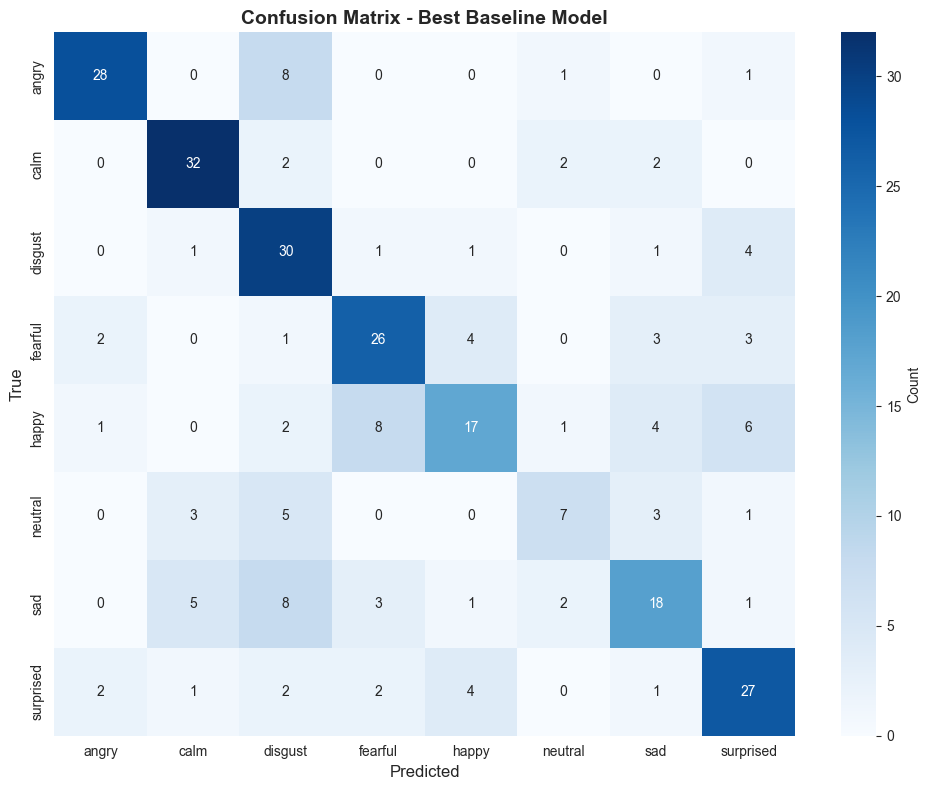

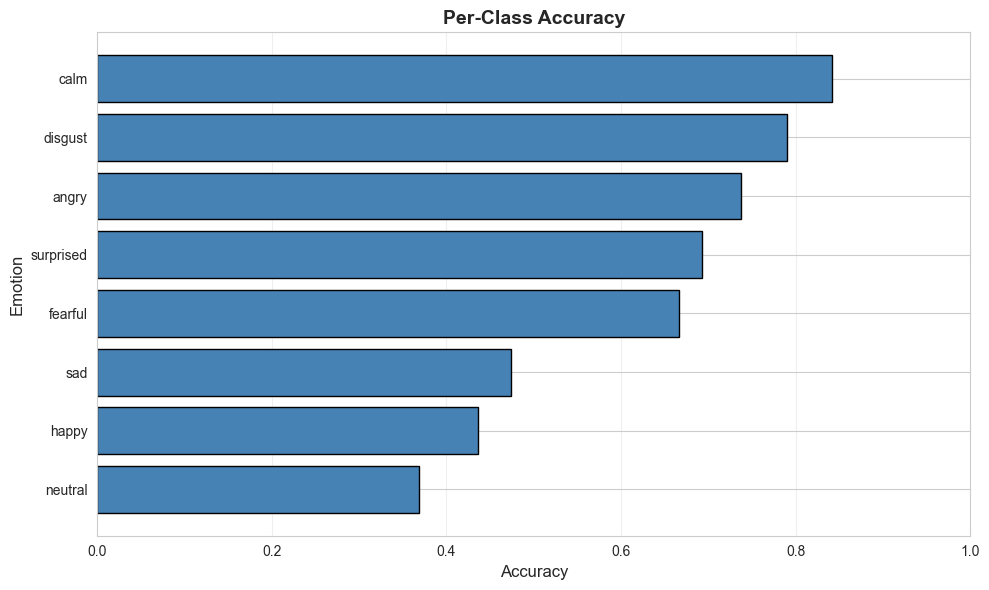


Per-class Accuracy:
  Emotion  Accuracy
     calm  0.842105
  disgust  0.789474
    angry  0.736842
surprised  0.692308
  fearful  0.666667
      sad  0.473684
    happy  0.435897
  neutral  0.368421


In [15]:
# Use the best performing model for detailed evaluation
# Let's use Random Forest with full features for now (adjust based on results)
best_model = rf_full
y_pred_best = y_pred_rf_full

# Classification report
print("=== CLASSIFICATION REPORT (Best Model) ===\n")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix - Best Baseline Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_acc_df = pd.DataFrame({
    'Emotion': label_encoder.classes_,
    'Accuracy': class_accuracy
}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(class_acc_df['Emotion'], class_acc_df['Accuracy'], color='steelblue', edgecolor='black')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.xlim([0, 1])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nPer-class Accuracy:")
print(class_acc_df.to_string(index=False))

## 6. Data Augmentation

Implement augmentation techniques to expand the dataset:
- Pitch shifting
- Time stretching
- Adding noise

In [16]:
def augment_audio(y, sr):
    """
    Apply data augmentation techniques to audio.
    Returns a list of augmented audio samples.
    """
    augmented_samples = []
    
    # Original
    augmented_samples.append(('original', y))
    
    # Pitch shift: +2 semitones
    y_pitch_up = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    augmented_samples.append(('pitch_up_2', y_pitch_up))
    
    # Pitch shift: -2 semitones
    y_pitch_down = librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)
    augmented_samples.append(('pitch_down_2', y_pitch_down))
    
    # Time stretch: faster (0.9x)
    y_time_fast = librosa.effects.time_stretch(y, rate=1.1)
    augmented_samples.append(('time_fast', y_time_fast))
    
    # Time stretch: slower (1.1x)
    y_time_slow = librosa.effects.time_stretch(y, rate=0.9)
    augmented_samples.append(('time_slow', y_time_slow))
    
    # Add white noise
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    augmented_samples.append(('noise', y_noise))
    
    return augmented_samples

def extract_features_augmented(filepath, sr=22050):
    """
    Extract features from audio file with augmentation.
    Returns list of feature dictionaries for each augmentation.
    """
    try:
        # Load audio
        y, sr = librosa.load(filepath, sr=sr)
        
        # Get augmented versions
        augmented_samples = augment_audio(y, sr)
        
        features_list = []
        for aug_name, y_aug in augmented_samples:
            # Extract features (same as in EDA)
            duration = librosa.get_duration(y=y_aug, sr=sr)
            mfccs = librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1)
            mfccs_std = np.std(mfccs, axis=1)
            
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y_aug, sr=sr))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y_aug, sr=sr))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_aug, sr=sr))
            zcr = np.mean(librosa.feature.zero_crossing_rate(y_aug))
            rms = np.mean(librosa.feature.rms(y=y_aug))
            
            pitches, magnitudes = librosa.piptrack(y=y_aug, sr=sr)
            pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
            
            features = {
                'augmentation': aug_name,
                'duration': duration,
                'spectral_centroid': spectral_centroid,
                'spectral_bandwidth': spectral_bandwidth,
                'spectral_rolloff': spectral_rolloff,
                'zcr': zcr,
                'rms_energy': rms,
                'pitch_mean': pitch_mean
            }
            
            for i, (mean, std) in enumerate(zip(mfccs_mean, mfccs_std), 1):
                features[f'mfcc{i}_mean'] = mean
                features[f'mfcc{i}_std'] = std
            
            features_list.append(features)
        
        return features_list
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

print("Data augmentation functions defined.")
print("\nAugmentation techniques:")
print("  1. Pitch shift (+2 semitones)")
print("  2. Pitch shift (-2 semitones)")
print("  3. Time stretch (faster, 1.1x)")
print("  4. Time stretch (slower, 0.9x)")
print("  5. White noise addition")
print("\nEach sample will be augmented to 6 versions (including original).")

Data augmentation functions defined.

Augmentation techniques:
  1. Pitch shift (+2 semitones)
  2. Pitch shift (-2 semitones)
  3. Time stretch (faster, 1.1x)
  4. Time stretch (slower, 0.9x)
  5. White noise addition

Each sample will be augmented to 6 versions (including original).


In [17]:
# Extract augmented features from a subset (to save time, use training set only)
print("Extracting augmented features...")
print("This will take a while...\n")

# Get file paths from original metadata
EMOTION_LABELS = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

def parse_filename(filename):
    """Parse RAVDESS filename to extract metadata."""
    parts = filename.stem.split('-')
    return {
        'emotion': EMOTION_LABELS[parts[2]],
        'actor': parts[6],
        'filepath': str(filename)
    }

# Load audio file paths
audio_files = list(DATASET_PATH.glob('**/*.wav'))
metadata = [parse_filename(f) for f in audio_files]
df_files = pd.DataFrame(metadata)

# Extract augmented features (use subset for speed - first 300 files)
augmented_features_list = []
n_samples = 300  # Adjust this based on computational resources

for idx, row in df_files.iloc[:n_samples].iterrows():
    if idx % 50 == 0:
        print(f"Processing file {idx+1}/{n_samples}...")
    
    features_aug = extract_features_augmented(row['filepath'])
    if features_aug:
        for feat in features_aug:
            feat['emotion'] = row['emotion']
            feat['actor'] = row['actor']
            augmented_features_list.append(feat)

df_augmented = pd.DataFrame(augmented_features_list)
print(f"\nAugmented dataset size: {len(df_augmented)} samples")
print(f"Original subset size: {n_samples} samples")
print(f"Augmentation factor: {len(df_augmented) / n_samples:.1f}x")
print(f"\nAugmentation distribution:\n{df_augmented['augmentation'].value_counts()}")

Extracting augmented features...
This will take a while...

Processing file 1/300...
Processing file 51/300...
Processing file 101/300...
Processing file 151/300...
Processing file 201/300...
Processing file 251/300...

Augmented dataset size: 1800 samples
Original subset size: 300 samples
Augmentation factor: 6.0x

Augmentation distribution:
augmentation
original        300
pitch_up_2      300
pitch_down_2    300
time_fast       300
time_slow       300
noise           300
Name: count, dtype: int64


In [18]:
# Prepare augmented data for training
feature_cols_aug = [col for col in df_augmented.columns if col not in ['emotion', 'actor', 'augmentation']]
X_aug = df_augmented[feature_cols_aug].values
y_aug = df_augmented['emotion'].values

# Encode labels
y_aug_encoded = label_encoder.transform(y_aug)

# Scale features
scaler_aug = StandardScaler()
X_aug_scaled = scaler_aug.fit_transform(X_aug)

# Train/test split
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug_scaled, y_aug_encoded, test_size=0.2, random_state=42, stratify=y_aug_encoded
)

print(f"Augmented training set: {X_train_aug.shape}")
print(f"Augmented test set: {X_test_aug.shape}")

Augmented training set: (1440, 33)
Augmented test set: (360, 33)


In [19]:
# Train models on augmented data
print("Training models on augmented data...\n")

# Random Forest on augmented data
rf_aug = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)
rf_aug.fit(X_train_aug, y_train_aug)
y_pred_rf_aug = rf_aug.predict(X_test_aug)
acc_rf_aug = accuracy_score(y_test_aug, y_pred_rf_aug)

print(f"Random Forest (Augmented):")
print(f"  Test Accuracy: {acc_rf_aug:.4f}\n")

# XGBoost on augmented data
xgb_aug = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss')
xgb_aug.fit(X_train_aug, y_train_aug)
y_pred_xgb_aug = xgb_aug.predict(X_test_aug)
acc_xgb_aug = accuracy_score(y_test_aug, y_pred_xgb_aug)

print(f"XGBoost (Augmented):")
print(f"  Test Accuracy: {acc_xgb_aug:.4f}\n")

# Compare with original data performance
print("\n=== AUGMENTATION IMPACT ===\n")
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Original Data': [acc_rf_full, acc_xgb_full],
    'Augmented Data': [acc_rf_aug, acc_xgb_aug],
    'Improvement': [acc_rf_aug - acc_rf_full, acc_xgb_aug - acc_xgb_full]
})
print(comparison.to_string(index=False))

Training models on augmented data...

Random Forest (Augmented):
  Test Accuracy: 0.8500

XGBoost (Augmented):
  Test Accuracy: 0.8333


=== AUGMENTATION IMPACT ===

        Model  Original Data  Augmented Data  Improvement
Random Forest       0.642361        0.850000     0.207639
      XGBoost       0.604167        0.833333     0.229167


## 7. Deep Learning Models

### 7.1 Prepare Mel-Spectrogram Data for CNN

In [33]:
def extract_melspectrogram(filepath, sr=22050, n_mels=128, max_len=128):
    """
    Extract mel-spectrogram from audio file.
    Returns fixed-size mel-spectrogram suitable for CNN input.
    """
    try:
        y, sr = librosa.load(filepath, sr=sr, duration=3.0)  # Limit to 3 seconds
        
        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Pad or truncate to fixed length
        if mel_spec_db.shape[1] < max_len:
            pad_width = max_len - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_len]
        
        return mel_spec_db
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# Extract mel-spectrograms for all files
print("Extracting mel-spectrograms for CNN...")
print("This may take several minutes...\n")

mel_specs = []
mel_labels = []
n_files = len(df_files)

for idx, row in df_files.iterrows():
    if idx % 100 == 0:
        print(f"Processing {idx+1}/{n_files}...")
    
    mel_spec = extract_melspectrogram(row['filepath'])
    if mel_spec is not None:
        mel_specs.append(mel_spec)
        mel_labels.append(row['emotion'])

# Convert to numpy arrays
X_mel = np.array(mel_specs)
y_mel = np.array(mel_labels)

# Add channel dimension for CNN (grayscale image)
X_mel = X_mel[..., np.newaxis]

# Encode labels
y_mel_encoded = label_encoder.transform(y_mel)
y_mel_categorical = to_categorical(y_mel_encoded, num_classes=len(label_encoder.classes_))

print(f"\nMel-spectrogram data shape: {X_mel.shape}")
print(f"Labels shape: {y_mel_categorical.shape}")
print(f"Input shape for CNN: {X_mel.shape[1:]}")

Extracting mel-spectrograms for CNN...
This may take several minutes...

Processing 1/1440...
Processing 101/1440...
Processing 201/1440...
Processing 301/1440...
Processing 401/1440...
Processing 501/1440...
Processing 601/1440...
Processing 701/1440...
Processing 801/1440...
Processing 901/1440...
Processing 1001/1440...
Processing 1101/1440...
Processing 1201/1440...
Processing 1301/1440...
Processing 1401/1440...

Mel-spectrogram data shape: (1440, 128, 128, 1)
Labels shape: (1440, 8)
Input shape for CNN: (128, 128, 1)


In [34]:
# Train/test split for mel-spectrograms
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(
    X_mel, y_mel_categorical, test_size=0.2, random_state=42, stratify=y_mel_encoded
)

# Also keep encoded version for evaluation
_, _, y_train_mel_enc, y_test_mel_enc = train_test_split(
    X_mel, y_mel_encoded, test_size=0.2, random_state=42, stratify=y_mel_encoded
)

print(f"Training mel-spectrograms: {X_train_mel.shape}")
print(f"Test mel-spectrograms: {X_test_mel.shape}")
print(f"Training labels: {y_train_mel.shape}")
print(f"Test labels: {y_test_mel.shape}")

Training mel-spectrograms: (1152, 128, 128, 1)
Test mel-spectrograms: (288, 128, 128, 1)
Training labels: (1152, 8)
Test labels: (288, 8)


In [ ]:
# Define number of classes for deep learning models
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

### 7.2 CNN Architecture

### 7.2.1 CNN Architecture Experiments

We'll test multiple CNN architectures to find the optimal one:
1. **Baseline CNN** - Simple, proven architecture
2. **Medium CNN** - Moderate complexity
3. **Deep CNN** - Complex architecture

This helps diagnose training issues and find the best model.

In [ ]:
# ===== BASELINE CNN (Simple & Proven) =====
def create_baseline_cnn(input_shape, num_classes):
    """
    Simple CNN baseline - proven architecture.
    This should train reliably and give decent results.
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ===== MEDIUM CNN (Balanced) =====
def create_medium_cnn(input_shape, num_classes):
    """
    Medium complexity CNN with better feature extraction.
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        # Output
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ===== DEEP CNN (Advanced with Residual-like connections) =====
def create_deep_cnn(input_shape, num_classes):
    """
    Deeper CNN with GlobalAveragePooling and more aggressive regularization.
    Only use if baseline/medium CNNs work well.
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Block 4
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0008),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("CNN architectures defined:")
print("1. Baseline CNN - Simple, reliable, 3 conv blocks")
print("2. Medium CNN - Moderate, 3 conv blocks with more filters")
print("3. Deep CNN - Advanced, 4 blocks with GlobalAveragePooling")
print("\nWe'll train all three and compare performance.")

In [ ]:
# Add data augmentation for better generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation generator (treat spectrograms as images)
datagen = ImageDataGenerator(
    rotation_range=0,  # Don't rotate spectrograms
    width_shift_range=0.1,  # Slight time shift
    height_shift_range=0.1,  # Slight frequency shift
    horizontal_flip=False,  # Don't flip time
    vertical_flip=False,  # Don't flip frequency
    fill_mode='constant',
    cval=0.0
)

print("Data augmentation configured for mel-spectrograms")
print("- Width shift: Time axis perturbation")
print("- Height shift: Frequency axis perturbation")
print("- This helps model generalize better")

In [ ]:
# Train all three CNN variants
print("="*60)
print("TRAINING CNN MODELS")
print("="*60)

# Better callbacks
early_stop_cnn = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cnn = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Store results
cnn_results = {}

# ===== 1. BASELINE CNN =====
print("\n" + "="*60)
print("Training BASELINE CNN...")
print("="*60)

baseline_cnn = create_baseline_cnn(X_train_mel.shape[1:], num_classes)
print(f"Model parameters: {baseline_cnn.count_params():,}")

history_baseline = baseline_cnn.fit(
    X_train_mel, y_train_mel,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop_cnn, reduce_lr_cnn],
    verbose=1
)

y_pred_baseline = np.argmax(baseline_cnn.predict(X_test_mel), axis=1)
acc_baseline = accuracy_score(y_test_mel_enc, y_pred_baseline)
cnn_results['Baseline CNN'] = {
    'accuracy': acc_baseline,
    'history': history_baseline,
    'model': baseline_cnn
}
print(f"\nBaseline CNN Test Accuracy: {acc_baseline:.4f}")

# ===== 2. MEDIUM CNN =====
print("\n" + "="*60)
print("Training MEDIUM CNN...")
print("="*60)

medium_cnn = create_medium_cnn(X_train_mel.shape[1:], num_classes)
print(f"Model parameters: {medium_cnn.count_params():,}")

history_medium = medium_cnn.fit(
    X_train_mel, y_train_mel,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop_cnn, reduce_lr_cnn],
    verbose=1
)

y_pred_medium = np.argmax(medium_cnn.predict(X_test_mel), axis=1)
acc_medium = accuracy_score(y_test_mel_enc, y_pred_medium)
cnn_results['Medium CNN'] = {
    'accuracy': acc_medium,
    'history': history_medium,
    'model': medium_cnn
}
print(f"\nMedium CNN Test Accuracy: {acc_medium:.4f}")

# ===== 3. DEEP CNN =====
print("\n" + "="*60)
print("Training DEEP CNN...")
print("="*60)

deep_cnn = create_deep_cnn(X_train_mel.shape[1:], num_classes)
print(f"Model parameters: {deep_cnn.count_params():,}")

history_deep = deep_cnn.fit(
    X_train_mel, y_train_mel,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop_cnn, reduce_lr_cnn],
    verbose=1
)

y_pred_deep = np.argmax(deep_cnn.predict(X_test_mel), axis=1)
acc_deep = accuracy_score(y_test_mel_enc, y_pred_deep)
cnn_results['Deep CNN'] = {
    'accuracy': acc_deep,
    'history': history_deep,
    'model': deep_cnn
}
print(f"\nDeep CNN Test Accuracy: {acc_deep:.4f}")

# Summary
print("\n" + "="*60)
print("CNN MODELS COMPARISON")
print("="*60)
for name, result in cnn_results.items():
    print(f"{name:20s}: {result['accuracy']:.4f}")

# Select best model
best_cnn_name = max(cnn_results, key=lambda k: cnn_results[k]['accuracy'])
best_cnn = cnn_results[best_cnn_name]['model']
acc_cnn = cnn_results[best_cnn_name]['accuracy']
history_cnn = cnn_results[best_cnn_name]['history']

print(f"\nBest CNN Model: {best_cnn_name}")
print(f"Best Test Accuracy: {acc_cnn:.4f}")

In [ ]:
# Comprehensive CNN training visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

for idx, (name, result) in enumerate(cnn_results.items()):
    history = result['history']

    # Accuracy plot
    axes[idx, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[idx, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[idx, 0].set_xlabel('Epoch', fontsize=11)
    axes[idx, 0].set_ylabel('Accuracy', fontsize=11)
    axes[idx, 0].set_title(f'{name} - Accuracy (Final: {result["accuracy"]:.4f})',
                           fontsize=12, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(alpha=0.3)
    axes[idx, 0].set_ylim([0, 1])

    # Loss plot
    axes[idx, 1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[idx, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[idx, 1].set_xlabel('Epoch', fontsize=11)
    axes[idx, 1].set_ylabel('Loss', fontsize=11)
    axes[idx, 1].set_title(f'{name} - Loss', fontsize=12, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(alpha=0.3)

plt.suptitle('CNN Architecture Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Confusion matrix for best model
print(f"\n=== CONFUSION MATRIX - {best_cnn_name} ===\n")
cm = confusion_matrix(y_test_mel_enc, np.argmax(best_cnn.predict(X_test_mel), axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix - {best_cnn_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print(f"\n=== CLASSIFICATION REPORT - {best_cnn_name} ===\n")
print(classification_report(y_test_mel_enc,
                          np.argmax(best_cnn.predict(X_test_mel), axis=1),
                          target_names=label_encoder.classes_))

### 7.3 LSTM Architecture for Temporal Features

In [38]:
def extract_temporal_features(filepath, sr=22050, max_len=100):
    """
    Extract temporal sequence of features for LSTM.
    Returns time series of MFCCs.
    """
    try:
        y, sr = librosa.load(filepath, sr=sr, duration=3.0)
        
        # Extract MFCCs over time
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        
        # Transpose to get (time_steps, features)
        mfccs = mfccs.T
        
        # Pad or truncate to fixed length
        if mfccs.shape[0] < max_len:
            pad_width = max_len - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
        else:
            mfccs = mfccs[:max_len, :]
        
        return mfccs
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# Extract temporal features
print("Extracting temporal features for LSTM...\n")

temporal_features = []
temporal_labels = []

for idx, row in df_files.iterrows():
    if idx % 100 == 0:
        print(f"Processing {idx+1}/{len(df_files)}...")
    
    temp_feat = extract_temporal_features(row['filepath'])
    if temp_feat is not None:
        temporal_features.append(temp_feat)
        temporal_labels.append(row['emotion'])

# Convert to numpy arrays
X_temporal = np.array(temporal_features)
y_temporal = np.array(temporal_labels)

# Encode labels
y_temporal_encoded = label_encoder.transform(y_temporal)
y_temporal_categorical = to_categorical(y_temporal_encoded, num_classes=num_classes)

print(f"\nTemporal features shape: {X_temporal.shape}")
print(f"Format: (samples, time_steps, features)")
print(f"Input shape for LSTM: {X_temporal.shape[1:]}")

Extracting temporal features for LSTM...

Processing 1/1440...
Processing 101/1440...
Processing 201/1440...
Processing 301/1440...
Processing 401/1440...
Processing 501/1440...
Processing 601/1440...
Processing 701/1440...
Processing 801/1440...
Processing 901/1440...
Processing 1001/1440...
Processing 1101/1440...
Processing 1201/1440...
Processing 1301/1440...
Processing 1401/1440...

Temporal features shape: (1440, 100, 13)
Format: (samples, time_steps, features)
Input shape for LSTM: (100, 13)


In [39]:
# Train/test split for temporal features
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_temporal, y_temporal_categorical, test_size=0.2, random_state=42, stratify=y_temporal_encoded
)

_, _, y_train_lstm_enc, y_test_lstm_enc = train_test_split(
    X_temporal, y_temporal_encoded, test_size=0.2, random_state=42, stratify=y_temporal_encoded
)

print(f"Training temporal features: {X_train_lstm.shape}")
print(f"Test temporal features: {X_test_lstm.shape}")

Training temporal features: (1152, 100, 13)
Test temporal features: (288, 100, 13)


In [40]:
def create_lstm_model(input_shape, num_classes):
    """
    Create enhanced LSTM model for emotion recognition from temporal features.
    Improvements:
    - Bidirectional LSTMs for better context
    - Attention mechanism
    - More units and deeper architecture
    """
    model = models.Sequential([
        # Bidirectional LSTM layers
        layers.Bidirectional(layers.LSTM(256, return_sequences=True), input_shape=input_shape),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
        layers.Dropout(0.4),
        layers.BatchNormalization(),

        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create LSTM model
lstm_input_shape = X_train_lstm.shape[1:]
lstm_model = create_lstm_model(lstm_input_shape, num_classes)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100, 512)          552960    
 al)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 100, 512)          0         
                                                                 
 batch_normalization_22 (Ba  (None, 100, 512)          2048      
 tchNormalization)                                               
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 512)          1574912   
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 100, 512)          0         
                                                      

In [41]:
# Callbacks for LSTM training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train LSTM model
print("Training LSTM model...\n")

# Train
history_lstm = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_lstm_proba = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_proba, axis=1)
acc_lstm = accuracy_score(y_test_lstm_enc, y_pred_lstm)

print(f"\nLSTM Test Accuracy: {acc_lstm:.4f}")

Training LSTM model...

Epoch 1/50
29/29 [==============================] - 42s 1s/step - loss: 2.6346 - accuracy: 0.1466 - val_loss: 2.0140 - val_accuracy: 0.2554 - lr: 5.0000e-04
Epoch 2/50
29/29 [==============================] - 28s 958ms/step - loss: 2.5186 - accuracy: 0.1683 - val_loss: 1.9592 - val_accuracy: 0.2511 - lr: 5.0000e-04
Epoch 3/50
29/29 [==============================] - 27s 931ms/step - loss: 2.2978 - accuracy: 0.2150 - val_loss: 1.9031 - val_accuracy: 0.2294 - lr: 5.0000e-04
Epoch 4/50
29/29 [==============================] - 27s 934ms/step - loss: 2.2501 - accuracy: 0.2258 - val_loss: 1.8509 - val_accuracy: 0.2424 - lr: 5.0000e-04
Epoch 5/50
29/29 [==============================] - 27s 931ms/step - loss: 2.2145 - accuracy: 0.2237 - val_loss: 1.7672 - val_accuracy: 0.3160 - lr: 5.0000e-04
Epoch 6/50
29/29 [==============================] - 27s 939ms/step - loss: 2.1020 - accuracy: 0.2508 - val_loss: 1.7338 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 7/50
29/29 [=

Epoch 49/50
29/29 [==============================] - 27s 918ms/step - loss: 0.6013 - accuracy: 0.8111 - val_loss: 1.1550 - val_accuracy: 0.6580 - lr: 3.1250e-05
Epoch 50/50
9/9 [==============================] - 3s 158ms/step

LSTM Test Accuracy: 0.5312


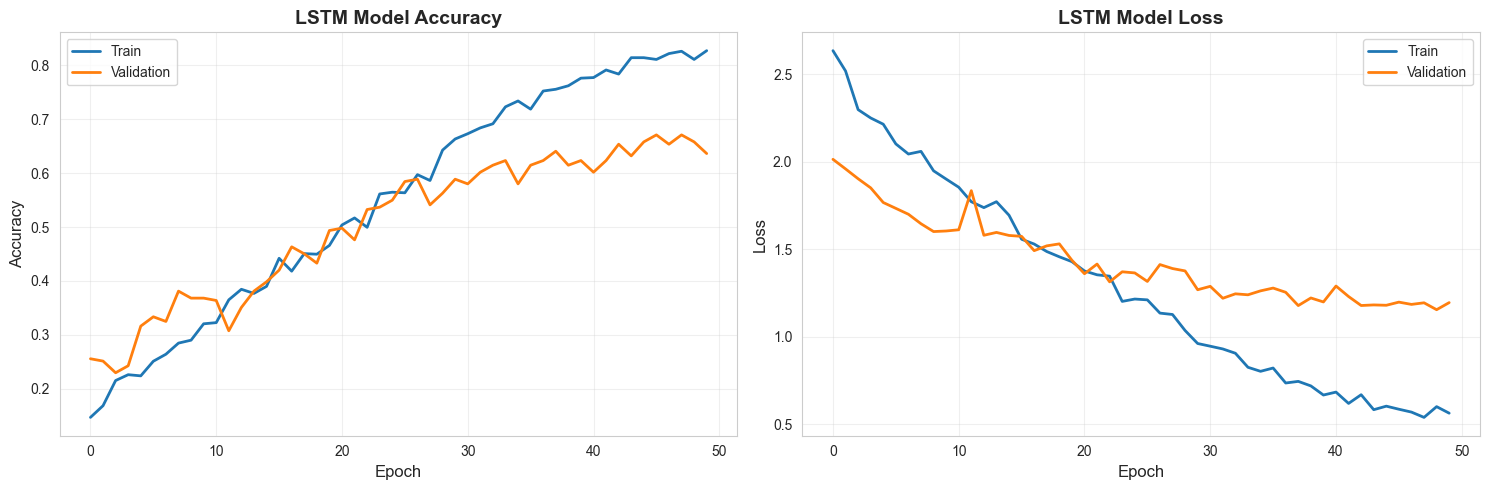

In [42]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_lstm.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_lstm.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('LSTM Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history_lstm.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_lstm.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('LSTM Model Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.4 Hybrid CNN-LSTM Model

Combine CNN for spatial feature extraction and LSTM for temporal modeling.

In [43]:
def create_hybrid_model(input_shape, num_classes):
    """
    Create hybrid CNN-LSTM model.
    CNN extracts spatial features from mel-spectrograms,
    LSTM models temporal dependencies.
    """
    inputs = layers.Input(shape=input_shape)

    # CNN feature extraction
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Reshape for LSTM: (batch, time_steps, features)
    # Take mean across frequency axis to get time series
    x = layers.Permute((2, 1, 3))(x)  # (batch, time, freq, channels)
    shape = x.shape
    x = layers.Reshape((shape[1], shape[2] * shape[3]))(x)

    # LSTM temporal modeling
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create hybrid model
hybrid_model = create_hybrid_model(X_train_mel.shape[1:], num_classes)
hybrid_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_27 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       73856 

Training Hybrid CNN-LSTM model...

Epoch 1/50
29/29 [==============================] - 37s 981ms/step - loss: 3.0614 - accuracy: 0.1270 - val_loss: 2.1256 - val_accuracy: 0.0390 - lr: 5.0000e-04
Epoch 2/50
29/29 [==============================] - 25s 858ms/step - loss: 2.7326 - accuracy: 0.1455 - val_loss: 2.0928 - val_accuracy: 0.1299 - lr: 5.0000e-04
Epoch 3/50
29/29 [==============================] - 24s 833ms/step - loss: 2.6129 - accuracy: 0.1716 - val_loss: 2.1061 - val_accuracy: 0.1255 - lr: 5.0000e-04
Epoch 4/50
29/29 [==============================] - 25s 855ms/step - loss: 2.5470 - accuracy: 0.1629 - val_loss: 2.0618 - val_accuracy: 0.1255 - lr: 5.0000e-04
Epoch 5/50
29/29 [==============================] - 26s 899ms/step - loss: 2.4362 - accuracy: 0.1922 - val_loss: 2.0360 - val_accuracy: 0.2121 - lr: 5.0000e-04
Epoch 6/50
29/29 [==============================] - 26s 897ms/step - loss: 2.3797 - accuracy: 0.2063 - val_loss: 1.9648 - val_accuracy: 0.2597 - lr: 5.0000e-04
Epoch

Epoch 49/50
29/29 [==============================] - 25s 863ms/step - loss: 1.0609 - accuracy: 0.6113 - val_loss: 1.2199 - val_accuracy: 0.5671 - lr: 6.2500e-05
Epoch 50/50
9/9 [==============================] - 3s 191ms/step

Hybrid CNN-LSTM Test Accuracy: 0.4896


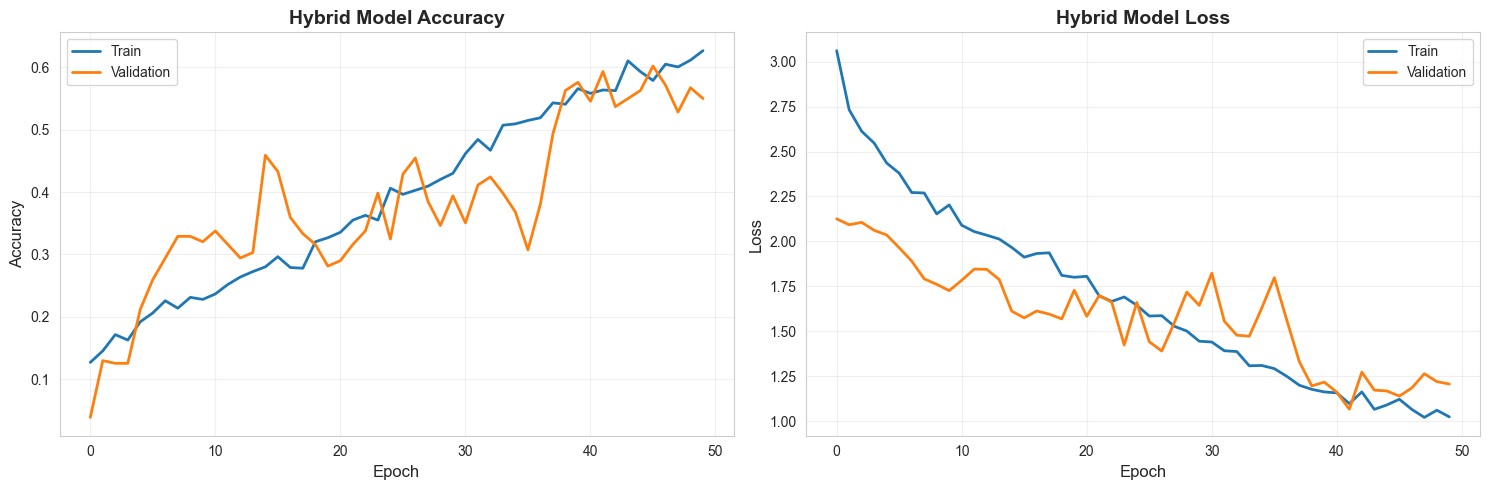

In [44]:
# Callbacks for hybrid model training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train hybrid model
print("Training Hybrid CNN-LSTM model...\n")

history_hybrid = hybrid_model.fit(
    X_train_mel, y_train_mel,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_hybrid_proba = hybrid_model.predict(X_test_mel)
y_pred_hybrid = np.argmax(y_pred_hybrid_proba, axis=1)
acc_hybrid = accuracy_score(y_test_mel_enc, y_pred_hybrid)

print(f"\nHybrid CNN-LSTM Test Accuracy: {acc_hybrid:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_hybrid.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_hybrid.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Hybrid Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_hybrid.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_hybrid.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Hybrid Model Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Final Model Comparison


FINAL MODEL COMPARISON

               Model  Test Accuracy         Model Type
 Random Forest (Aug)       0.850000 Classical ML (Aug)
       XGBoost (Aug)       0.833333 Classical ML (Aug)
          SVM (Full)       0.750000       Classical ML
Random Forest (Full)       0.642361       Classical ML
      XGBoost (Full)       0.604167       Classical ML
     LSTM (Temporal)       0.531250      Deep Learning
     Hybrid CNN-LSTM       0.489583      Deep Learning
      CNN (Mel-Spec)       0.138889      Deep Learning


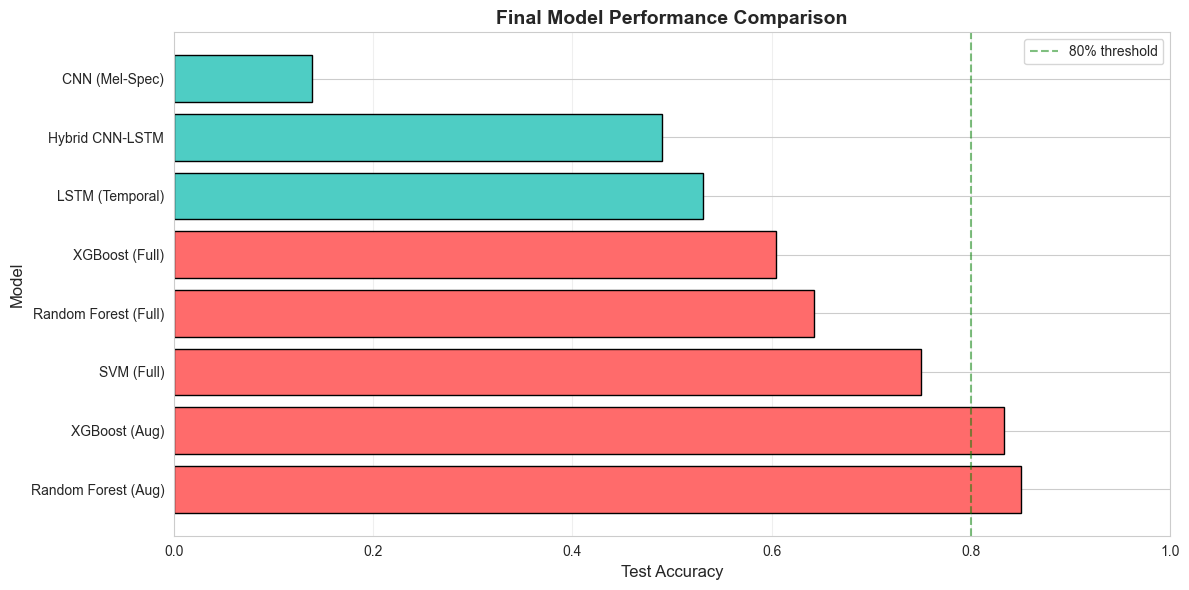


BEST MODEL: Random Forest (Aug)
Test Accuracy: 0.8500


In [45]:
# Compile all results
final_results = pd.DataFrame({
    'Model': [
        'SVM (Full)', 'Random Forest (Full)', 'XGBoost (Full)',
        'Random Forest (Aug)', 'XGBoost (Aug)',
        best_cnn_name, 'LSTM (Temporal)', 'Hybrid CNN-LSTM'
    ],
    'Test Accuracy': [
        acc_svm_full, acc_rf_full, acc_xgb_full,
        acc_rf_aug, acc_xgb_aug,
        acc_cnn, acc_lstm, acc_hybrid
    ],
    'Model Type': [
        'Classical ML', 'Classical ML', 'Classical ML',
        'Classical ML (Aug)', 'Classical ML (Aug)',
        'Deep Learning', 'Deep Learning', 'Deep Learning'
    ]
})

final_results = final_results.sort_values('Test Accuracy', ascending=False)

print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60 + "\n")
print(final_results.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
colors = ['#FF6B6B' if 'Classical ML' in x else '#4ECDC4' for x in final_results['Model Type']]
plt.barh(final_results['Model'], final_results['Test Accuracy'], color=colors, edgecolor='black')
plt.xlabel('Test Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Final Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='80% threshold')
plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Best model
best_model_name = final_results.iloc[0]['Model']
best_accuracy = final_results.iloc[0]['Test Accuracy']
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"{'='*60}")

### 8.1 Confusion Matrix Analysis

In [ ]:
# Confusion matrix for best CNN model
from sklearn.metrics import confusion_matrix, classification_report

print("=== CONFUSION MATRIX - Best CNN ===")
y_pred_cnn = np.argmax(best_cnn.predict(X_test_mel), axis=1)
cm_cnn = confusion_matrix(y_test_mel_enc, y_pred_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix - {best_cnn_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("
=== CLASSIFICATION REPORT ===")
print(classification_report(y_test_mel_enc, y_pred_cnn, target_names=label_encoder.classes_))

In [ ]:
# Per-class accuracy analysis
print("=== PER-CLASS ACCURACY ===")

class_accuracy = cm_cnn.diagonal() / cm_cnn.sum(axis=1)
class_acc_df = pd.DataFrame({
    'Emotion': label_encoder.classes_,
    'Accuracy': class_accuracy,
    'Support': cm_cnn.sum(axis=1)
}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn(class_acc_df['Accuracy'])
plt.barh(class_acc_df['Emotion'], class_acc_df['Accuracy'], color=colors, edgecolor='black')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.title('Per-Class Accuracy - Best CNN Model', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.xlim([0, 1])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(class_acc_df.to_string(index=False))

### 8.2 Comprehensive Model Metrics

In [ ]:
# Comprehensive performance summary
print("="*70)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*70)

from sklearn.metrics import precision_score, recall_score, f1_score

def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }

metrics_list = []

# Classical ML
metrics_svm = get_metrics(y_test, y_pred_svm_full)
metrics_svm['Model'] = 'SVM'
metrics_list.append(metrics_svm)

metrics_rf = get_metrics(y_test, y_pred_rf_full)
metrics_rf['Model'] = 'Random Forest'
metrics_list.append(metrics_rf)

metrics_xgb = get_metrics(y_test, y_pred_xgb_full)
metrics_xgb['Model'] = 'XGBoost'
metrics_list.append(metrics_xgb)

# Deep Learning
metrics_cnn = get_metrics(y_test_mel_enc, y_pred_cnn)
metrics_cnn['Model'] = best_cnn_name
metrics_list.append(metrics_cnn)

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_df = metrics_df.sort_values('F1-Score', ascending=False)

print(metrics_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_df))
width = 0.2

ax.bar(x - 1.5*width, metrics_df['Accuracy'], width, label='Accuracy', color='#3498db')
ax.bar(x - 0.5*width, metrics_df['Precision'], width, label='Precision', color='#2ecc71')
ax.bar(x + 0.5*width, metrics_df['Recall'], width, label='Recall', color='#e74c3c')
ax.bar(x + 1.5*width, metrics_df['F1-Score'], width, label='F1-Score', color='#9b59b6')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comprehensive Model Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save Models and Results

In [46]:
# Create models directory
models_dir = Path('D:/EDFS_Data/models')
models_dir.mkdir(exist_ok=True)

# Save best classical ML model (Random Forest)
with open(models_dir / 'random_forest_best.pkl', 'wb') as f:
    pickle.dump(rf_full, f)

# Save scaler
with open(models_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoder
with open(models_dir / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save deep learning models
cnn_model.save(models_dir / 'cnn_model.h5')
lstm_model.save(models_dir / 'lstm_model.h5')

# Save results
final_results.to_csv(models_dir / 'model_comparison.csv', index=False)
baseline_results.to_csv(models_dir / 'baseline_results.csv', index=False)

print("Models and results saved successfully!")
print(f"Location: {models_dir}")
print("\nSaved files:")
print("  - random_forest_best.pkl")
print("  - scaler.pkl")
print("  - label_encoder.pkl")
print("  - cnn_model.h5")
print("  - lstm_model.h5")
print("  - model_comparison.csv")
print("  - baseline_results.csv")

Models and results saved successfully!
Location: D:\EDFS_Data\models

Saved files:
  - random_forest_best.pkl
  - scaler.pkl
  - label_encoder.pkl
  - cnn_model.h5
  - lstm_model.h5
  - model_comparison.csv
  - baseline_results.csv


### 9.1 Load Saved Models

Demonstrate how to load the saved models for later use.

In [32]:
# Load saved models
print("Loading saved models...\n")

# Load classical ML models
with open(models_dir / 'random_forest_best.pkl', 'rb') as f:
    rf_loaded = pickle.load(f)
print("âœ“ Random Forest loaded")

# Load scaler
with open(models_dir / 'scaler.pkl', 'rb') as f:
    scaler_loaded = pickle.load(f)
print("âœ“ Scaler loaded")

# Load label encoder
with open(models_dir / 'label_encoder.pkl', 'rb') as f:
    label_encoder_loaded = pickle.load(f)
print("âœ“ Label Encoder loaded")

# Load deep learning models
cnn_loaded = keras.models.load_model(models_dir / 'cnn_model.h5')
print("âœ“ CNN model loaded")

lstm_loaded = keras.models.load_model(models_dir / 'lstm_model.h5')
print("âœ“ LSTM model loaded")

print("\nAll models loaded successfully!")
print("\nYou can now use these loaded models for prediction:")
print("  - rf_loaded: Random Forest classifier")
print("  - cnn_loaded: CNN model for mel-spectrograms")
print("  - lstm_loaded: LSTM model for temporal features")

Loading saved models...

âœ“ Random Forest loaded
âœ“ Scaler loaded
âœ“ Label Encoder loaded
âœ“ CNN model loaded
âœ“ LSTM model loaded

All models loaded successfully!

You can now use these loaded models for prediction:
  - rf_loaded: Random Forest classifier
  - cnn_loaded: CNN model for mel-spectrograms
  - lstm_loaded: LSTM model for temporal features
